# Исользование моделей МО с целью определения стоимости автомобилей


**Описание проекта:**  Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта:** Нужно построить модель для определения стоимости. 


**План работ:**
- Загрузите данные, путь к файлу: /datasets/autos.csv.
- Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
- Подготовьте выборки для обучения моделей.
- Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
- Проанализируйте время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

**Примечания:**
- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

**Описание данных:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


- Price — цена (евро) - целевой признак

In [1]:
!pip install -Uq scikit-learn
!pip install -Uq phik
!pip install lightgbm

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from phik import report
from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import make_scorer, root_mean_squared_error, mean_squared_error

## Подготовка данных

### Загрузка данных

In [3]:
try:
    autos = pd.read_csv('/datasets/autos.csv')
except:
    try:
        autos = pd.read_csv('autos.csv')
    except:
        print('Something is wrong')

**Вывод:** Данные соответствуют описанию задачи. Названия столбцов необходимо будет изменить в соответствии со стандартами оформления данных на этапе предобработки. Присутсвуют пропуски, которые будут заполнены на этапе предобработки.

### Предобработка данных

In [4]:
#Приведение названий столбцов датафрейма к нормальному оформлению
autos.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year',
                'gearbox', 'power', 'model', 'kilometer', 'registration_month',
                'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures',
                'postal_code', 'last_seen']
autos.head()

In [5]:
#Проверка пропусков
autos.isna().sum()

In [6]:
autos['vehicle_type'].value_counts(dropna=False)

In [7]:
autos['vehicle_type'] = autos['vehicle_type'].fillna('unknown')

In [8]:
autos['gearbox'].value_counts(dropna=False)

In [9]:
autos['gearbox'] = autos['gearbox'].fillna('unknown')

In [10]:
autos['model'].value_counts(dropna=False)

In [11]:
autos['model'] = autos['model'].fillna('unknown')

In [12]:
autos['fuel_type'].value_counts(dropna=False)

In [13]:
autos['fuel_type'] = autos['fuel_type'].fillna('petrol')

In [14]:
autos['repaired'].value_counts(dropna=False)

In [15]:
autos['repaired'] = autos['repaired'].fillna('unknown')

In [16]:
#Проверка пропусков
autos.isna().sum()

In [17]:
#Поиск дубликатов и их удаление
print('Количество дубликатов до форматирования:', autos.duplicated().sum())
autos = autos.drop_duplicates()
print('Количество дубликатов после форматирования:', autos.duplicated().sum())

In [18]:
autos['fuel_type'] = autos['fuel_type'].replace(['gasoline'], 'petrol')

In [19]:
autos['model'] = autos['brand'].replace(['rangerover'], 'range_rover')

**Вывод:** На этапе предобработке данных были замечены пропуски, которые были удалены, так как нельзя было логически обосновать их заполнение другими значениями. Явные дубликаты были удалены. Неявные исправлены.

### Исследовательский анализ данных

In [20]:
autos.head()

In [21]:
#date_crawled — дата сбора данных не влияет на его цену
#model — модель может быть избыточной при наличии информации о марке автомобиля (brand)
#date_created — дата создания объявления не отражает характеристики автомобиля
#last_seen — дата последнего посещения объявления не отражает характеристики автомобиля
#number_of_pictures — количество картинок в объявлении  не отражает характеристики автомобиля и равно нулю
#postal_code — почтовый индекс не отражает характеристики автомобиля
#registration_month — месяц регистрации менее значим, чем год регистрации

prepared_autos = autos.drop(['date_crawled', 'model', 'date_created', 'last_seen', 
                             'number_of_pictures', 'postal_code', 'registration_month'], axis=1)

In [22]:
prepared_autos.head()

In [23]:
def num_research(data):
    num_cols = data.select_dtypes(include=['number']).columns
    num_plots = len(num_cols)
    
    plt.figure(figsize=(10, 5 * num_plots))
    for i, col in enumerate(num_cols):
        # Гистограмма
        plt.subplot(num_plots, 2, 2*i + 1)
        data[col].hist(bins=10)
        plt.title(f'Hist {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # Ящик
        plt.subplot(num_plots, 2, 2*i + 2)
        data.boxplot(column=col)
        plt.title(f'Box {col}')
        plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


In [24]:
def pie(data):
    # Выбираем все столбцы с типом данных 'object'
    cat_cols = data.select_dtypes(include=['object']).columns
    
    # Считаем количество столбцов для графиков
    num_plots = len(cat_cols)
    
    # Задаем размер фигуры, чтобы на каждую диаграмму было достаточно места
    plt.figure(figsize=(10, 5 * num_plots))
    
    # Построение пироговой диаграммы для каждого категориального столбца
    for i, col in enumerate(cat_cols):
        plt.subplot(num_plots, 2, i + 1)
        
        # Считаем количество значений в столбце и выбираем 10 самых частых
        value_counts = data[col].value_counts()
        top_8 = value_counts.nlargest(8)
        
        # Если есть значения, не вошедшие в топ-10, объединяем их в категорию 'Другие'
        if len(value_counts) > 8:
            top_8['Другие'] = value_counts[8:].sum()
        
        # Строим пироговую диаграмму
        top_8.plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'Pie {col}')
    
    # Подгоняем компоновку графиков
    plt.tight_layout()
    plt.show()

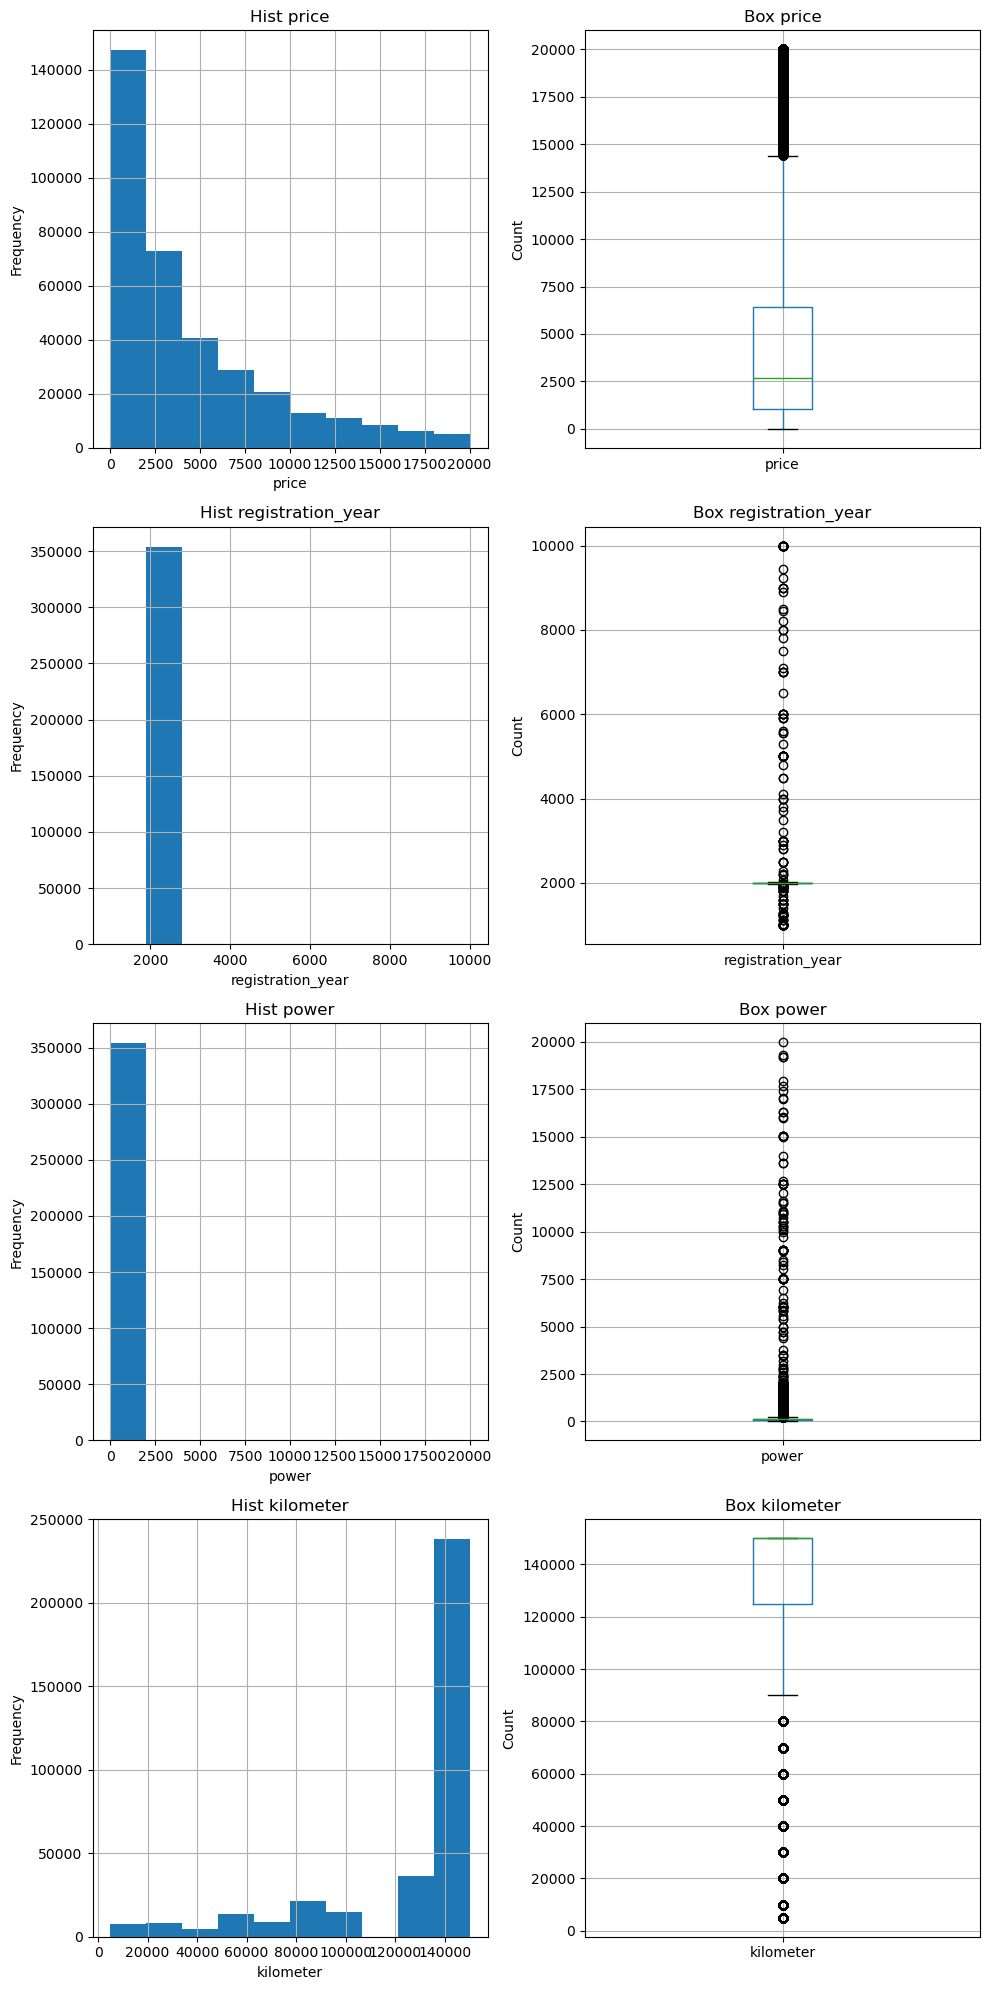

In [25]:
num_research(prepared_autos);

In [26]:
prepared_autos.describe()

In [27]:
#Удаление выбросов
prepared_autos = prepared_autos[prepared_autos['price'] < 15000]
prepared_autos = prepared_autos[prepared_autos['price'] > 500]
prepared_autos = prepared_autos[prepared_autos['price'] != 0]

In [28]:
prepared_autos = prepared_autos[prepared_autos['registration_year'] <= 2016]

In [29]:
prepared_autos = prepared_autos[prepared_autos['registration_year'] >= 1987]

In [30]:
prepared_autos = prepared_autos[prepared_autos['power'] <= 1000]
prepared_autos = prepared_autos[prepared_autos['power'] > 50]
prepared_autos = prepared_autos[prepared_autos['power'] != 0]

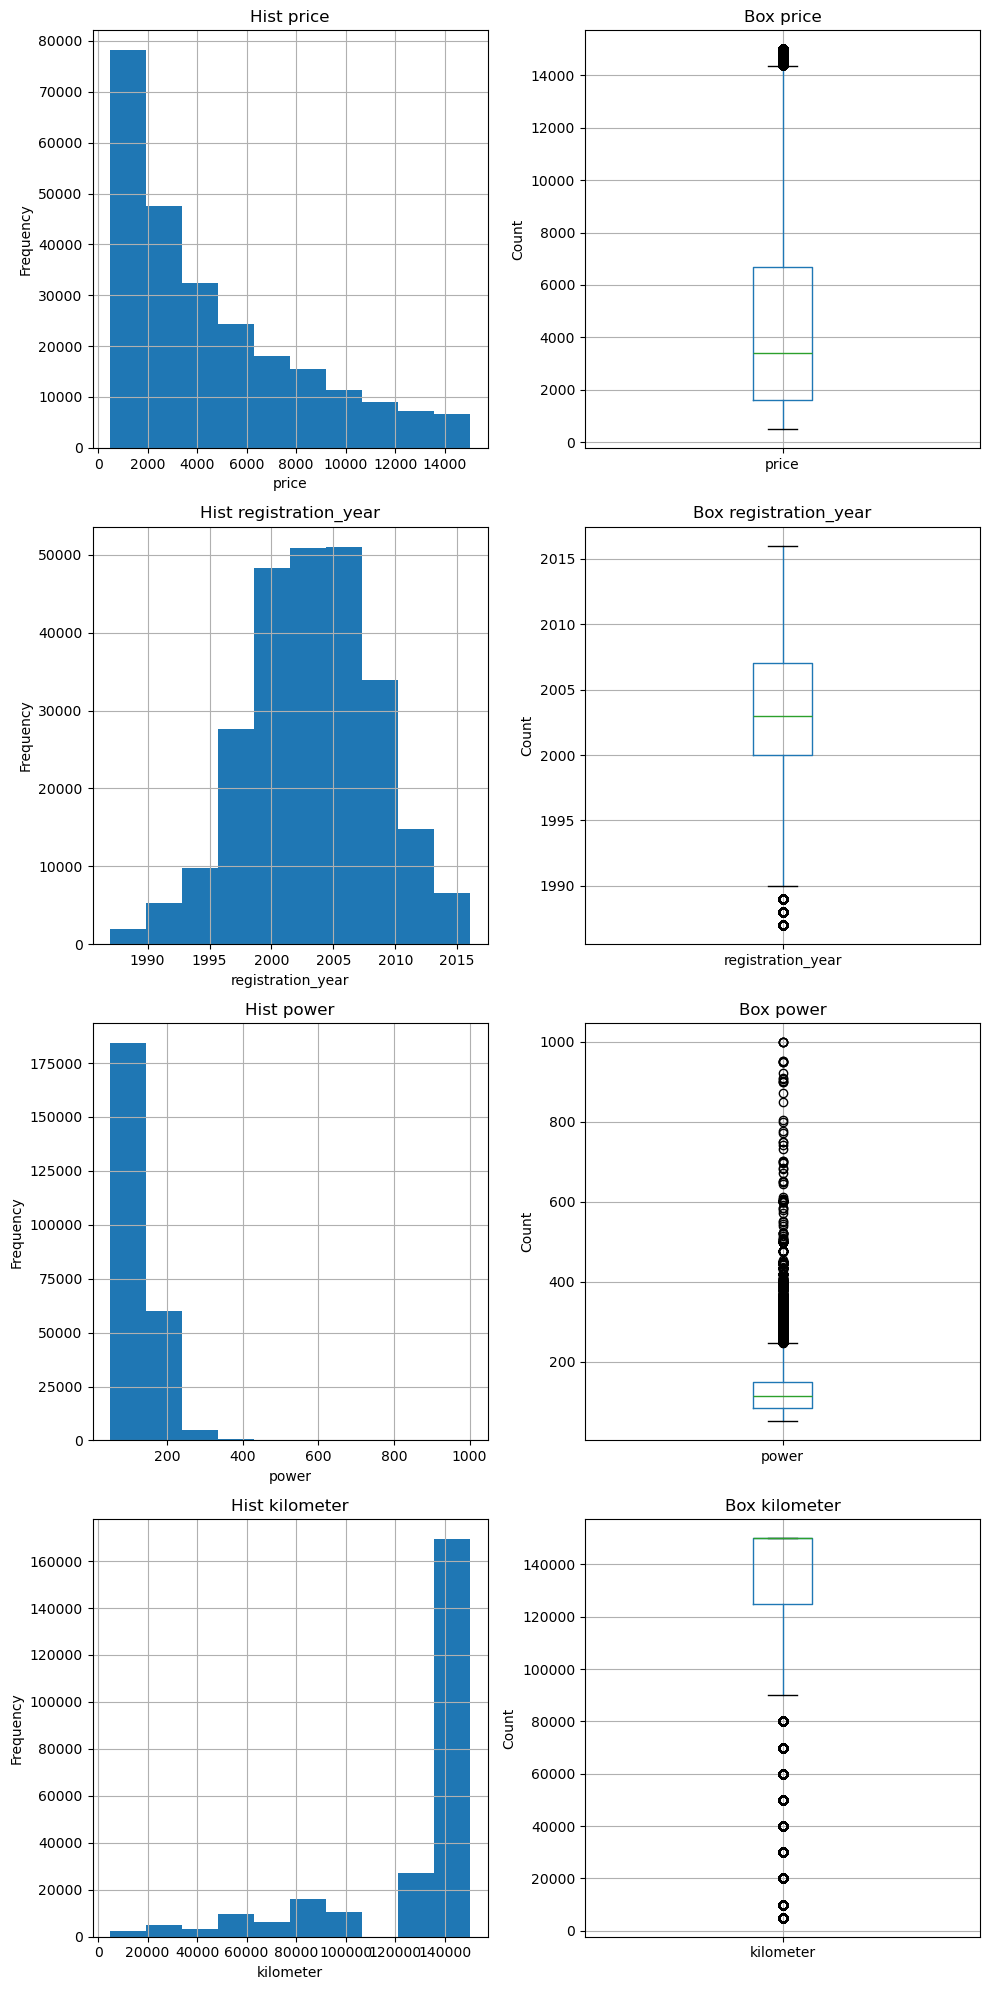

In [31]:
num_research(prepared_autos);

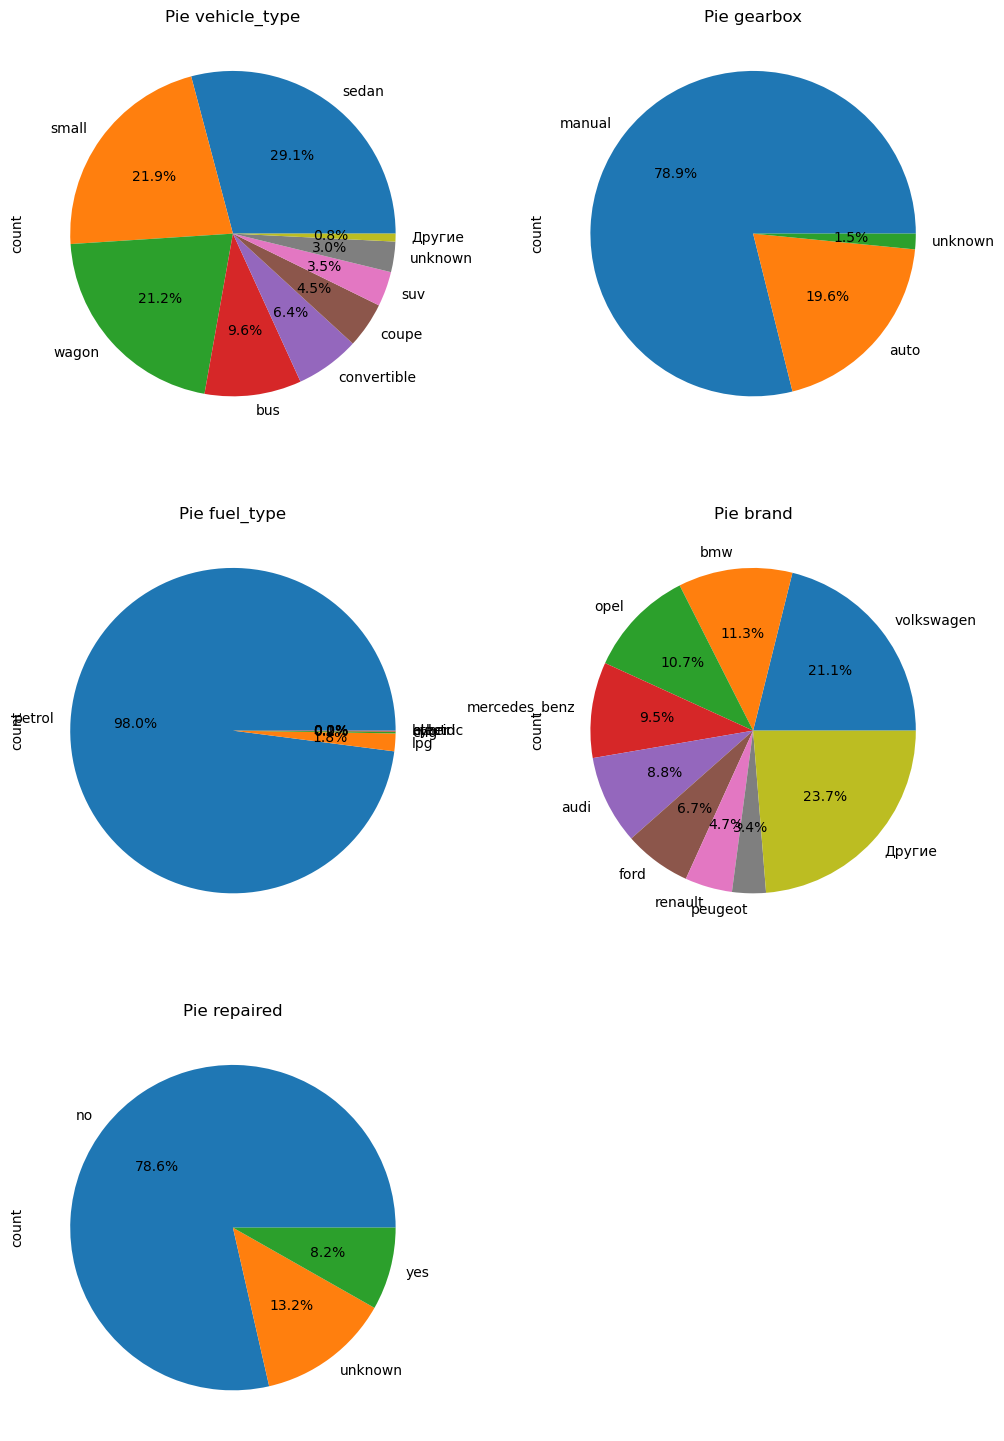

In [32]:
pie(prepared_autos)

In [33]:
# Матрица корреляции
interval_cols = prepared_autos.select_dtypes(include=['number']).columns
interval_cols = interval_cols.drop(['registration_year', 'kilometer'])

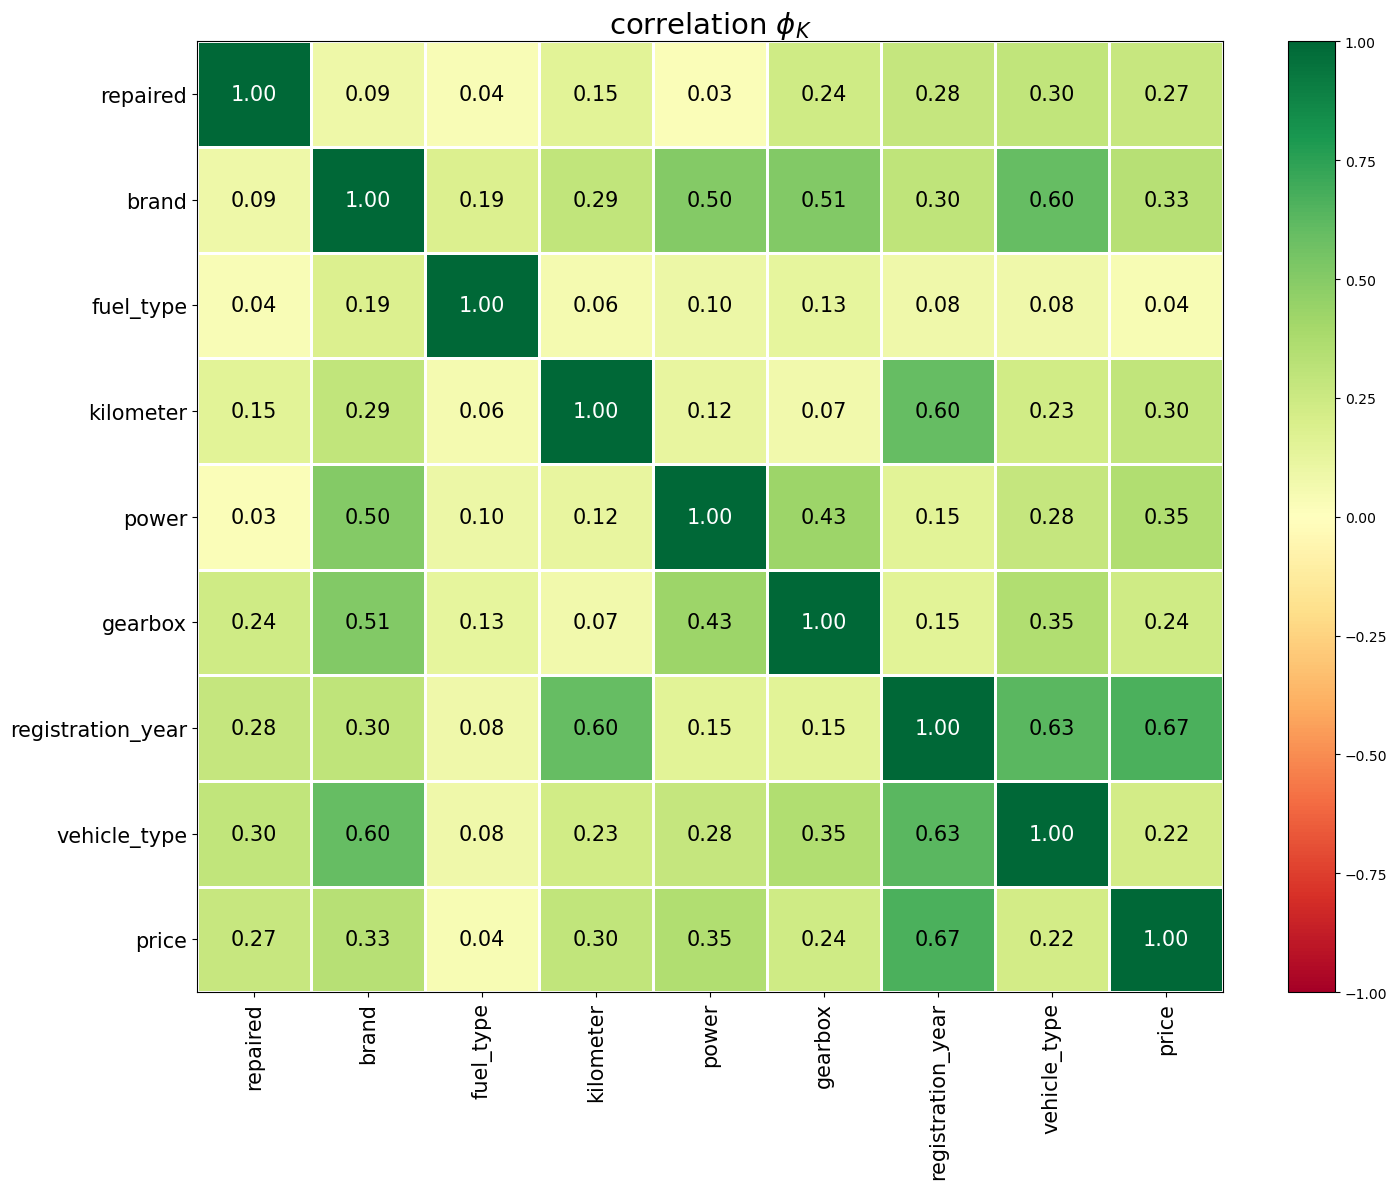

In [34]:
phik_overview = prepared_autos.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Вывод:** Лишние столбцы были удалены, а выбросы в оставшихся устранены. При проведении корреляционого анализа мультиколлинеарность не была выявлена.

### Подготовка данных

In [35]:
prepared_autos.head()

In [36]:
# Отбор признаков и разбиение на тренировочную и тестовую выборки
RANDOM_STATE = 42
X = prepared_autos.drop('price', axis=1)
y = prepared_autos['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)

In [37]:
# создаём списки с названиями признаков
ohe_columns = ['gearbox', 'vehicle_type', 'fuel_type', 'brand', 'repaired']
num_columns = ['registration_year', 'power', 'kilometer']

In [38]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [39]:
# Преобразуем данные с помощью пайплайна data_preprocessor
X_train_prepared = data_preprocessor.fit_transform(X_train)
X_test_prepared = data_preprocessor.transform(X_test)

In [40]:
print("Размер X_train до преобразования:", X_train.shape)
print("Размер X_train после преобразования:", X_train_prepared.shape)
print("Размер X_test после преобразования:", X_test_prepared.shape)

**Вывод:** Данные были разделены на тренировочную и тестовую выборки. Был создан пайплайн для подготовки данных.

## Обучение моделей

In [41]:
%%time
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_STATE = 42

pipe_final = Pipeline([
    ('models', LinearRegression())  
])

param_grid = [
    # Гиперпараметры для LinearRegression (без гиперпараметров) (Увеличим вероятность 
    # переобра за счет добавления нескольких модель типа LinearRegression)
    {
        'models': [LinearRegression()]
    },
    {
        'models': [LinearRegression()]
    },
    
    # Гиперпараметры для DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20, 2),
        'models__max_features': range(2, 10, 2)
    },
    
    # Гиперпараметры для LightGBM
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(1, 50, 2),
        'models__learning_rate': [0.01, 0.1, 0.2]
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_iter=75,  
    n_jobs=-1  
)

randomized_search.fit(X_train_prepared, y_train)

## Анализ моделей

In [42]:
cv_results = pd.DataFrame(randomized_search.cv_results_)

# Добавляем колонку с названием модели, выделяя её из параметра 'param_models'
cv_results['model_name'] = cv_results['param_models'].apply(lambda x: str(x).split('(')[0])

# Для каждой модели находим строку с минимальной метрикой RMSE (максимальный 'neg_root_mean_squared_error')
best_indices = cv_results.groupby('model_name')['mean_test_score'].idxmax()

# Извлекаем строки с минимальной метрикой для каждой модели
best_results = cv_results.loc[best_indices, ['model_name', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]

# Преобразуем обратно в положительный RMSE (метрика 'neg_root_mean_squared_error' отрицательная, поэтому инвертируем)
best_results['mean_test_score'] = -best_results['mean_test_score']

# Переименовываем столбцы для удобного восприятия
best_results.columns = ['Модель', 'RMSE', 'Время обучения', 'Время предсказания']

best_results

In [43]:
best_model = randomized_search.best_estimator_
y_test_predictions_bm = best_model.predict(X_test_prepared)

rmse_bm = root_mean_squared_error(y_test, y_test_predictions_bm)
print('RMSE:', rmse_bm)


**Вывод:**

Из всех протестированных моделей наименьшую ошибку RMSE показали:
- LGBMRegressor с RMSE = 1452.64, что указывает на его высокую точность в предсказаниях.
- DecisionTreeRegressor с RMSE = 1876.81, также демонстрирует неплохие результаты.
- LinearRegression оказалась наименее точной с RMSE = 2072.76

Время обучения и предсказания:
- DecisionTreeRegressor и LGBMRegressor имеют сопоставимое время обучения (3.37 и 0.56 секунды соответственно), и предсказания (0.005 и 0.03 секунды соответственно)
- LinearRegression показала наименьшее время обучения (0.29 секунды) и крайне малое время предсказания (0.001 секунды), что делает её быстрой, но менее точной по сравнению с другими моделями.

## Общий вывод

На этапе загрузки данных было выявлено, что они соответствуют описанию задачи.

На этапе предобработке данных были замечены пропуски, которые были удалены, так как нельзя было логически обосновать их заполнение другими значениями. Явные дубликаты были удалены. Неявные исправлены.

Во время исследовательского анализа данных лишние столбцы были удалены, а выбросы в оставшихся устранены. При проведении корреляционого анализа мультиколлинеарность не была выявлена. 

После чего во время подготовки данных они были разделены на тренировочную и тестовую выборки. Также был создан пайплайн для подготовки данных.


Из всех протестированных моделей наименьшую ошибку RMSE показали:
- LGBMRegressor с RMSE = 1452.64, что указывает на его высокую точность в предсказаниях.
- DecisionTreeRegressor с RMSE = 1876.81, также демонстрирует неплохие результаты.
- LinearRegression оказалась наименее точной с RMSE = 2072.76

Время обучения и предсказания:
- DecisionTreeRegressor и LGBMRegressor имеют сопоставимое время обучения (3.37 и 0.56 секунды соответственно), и предсказания (0.005 и 0.03 секунды соответственно)
- LinearRegression показала наименьшее время обучения (0.29 секунды) и крайне малое время предсказания (0.001 секунды), что делает её быстрой, но менее точной по сравнению с другими моделями.


Рекомендации:
- Несмотря на то, что модель LGBMRegressor показала самое долгое время обучения, которое все же сопоставимо со временем работы модели DecisionTreeRegressor и не на много превосходит его, она также показала наилучший результат на кросс-валидационной выборке - 1452.64, что существенно больше ее ближайшего конурента DecisionTreeRegressor с метрикой RMSE, равной 1876.81. Поэтому рекомендую использовать именно эту модель. Также она была проверена на тестовых данных, где показала себя незначительно лучше валидационных. RMSE составил 1449.48.
